Здравствуйте!

У меня задание 3

Задача 1.2.6:

$y'(t) = y \big( \frac{t}{(1+2t)^2} \big) ^{(1+2t)^2}$

$y(0) = 1$

При возникновении перекрытия я приближаю решение значением в начале совершаемого шага.

Скажем так, альфа-версия выпустилась, но выдает что-то очень не похожее на аналитическое решение ($y(t) = e^t$). И тут как бы одно из двух: оно работает правильно неправильно, потому что мы приближаем слишком грубо; оно работает неправильно неправильно, потому что у меня ошибка в алгоритме. Скорее всего второе, но тогда мне нужна помощь, я не знаю, где налажала:(
Я не прошу запускать этот ужас, только посмотреть на графики и по возможности на алгоритм, пожалуйста.

Вкратце про формат: это IPython notebook, язык python3. Почему он? Родней просто. Чем отличается от matlab? Честно говоря, не знаю, но вряд ли чем-то значимым. Умножается/делится/складывается всё так же.

In [66]:
y0 = 1
delay = lambda t: (1 + 2 * t) ** 2
f = lambda t, y, delayed_y: delayed_y[0] ** delay(t)

In [67]:
def heun_schema():
    b = lambda t: [(t - (3 / 2) * (t ** 2) + (2 / 3) * (t ** 3)),
                   (0),
                   (2 * (t ** 2) - (4 / 3) * (t ** 3)),
                   (-(1 / 2) * (t ** 2) + (2 / 3) * (t ** 3))]
    c = [(1), (1 / 2), (1)]
    a = lambda t1, t2, t3 : [[(t1)],
                    [(t2 - 1 / 2 * (t2 ** 2)), (1 / 2 * (t2 ** 2))],
                    [(t3 - 1 / 2 * (t3 ** 2)), (1 / 2 * (t3 ** 2)), 0]]
    return a, b, c

Наверху код вроде понятен, lambda x, y, z, ... : "тело функции" -- это краткий способ задать функцию. x, y, z -- переменные, тело функции -- некоторое одно выражение. y и delayed_y изначально считают векторами, t - скаляр. И да, heun_schema() -- функция, возвращающая две другие функции и вектор, так можно.

Ниже функция для поиска истории, delayed_t -- запоздавшее время, curr_y -- значение в начале совершаемого шага, которым я приближаю по дефолту, previous_funs -- вектор из кортежей ($t_i$, $t_{i+1}$, $\eta_i$), где $t_i$ и $t_{i+1}$ -- начало и конец промежутка, $\eta_i$ -- интерполянт на данном промежутке, принимающий значение от 0 до 1.

Соответственно, для запоздавшего t мы бегаем по всей предыстории, ищем отрезок, которому он принадлежит, определяем, в какую часть его он попадает по $\frac{t - t_i}{t_{i+1}- t_{i}}$ и получаем нужное значение. Если оно не найдено, возвращаем curr_y.

In [68]:
def get_y(delayed_t, previous_funs, curr_y):
    for (t_left, t_right, previous_fun) in previous_funs:
        if ((t_left < delayed_t or abs(t_left - delayed_t) < 0.001) and
            (delayed_t < t_right or abs(t_right - delayed_t) < 0.001)):
            theta = (delayed_t - t_left) / (t_right - t_left)
            return previous_fun(theta)
    return curr_y

Вот здесь нужно уточнение. Когда мы считаем $k_i$ и вызываем $f(t)$ (которая $y'(t)$), то в качестве запоздалых y мы отдаем ей $\eta(delay(t + c_i h)$, верно? то есть делаем шаг $t + c_i h$, ищем запаздывание от него и берем соответствующее ему значение предыстории и подставляем в $f()$?

Ну а так, t0 -- t на этом шаге, var_list -- y на этом шаге, fun_list -- список функций, delayed_var_list -- запоздавшие y в запоздашем t0, h -- шаг, get_schema -- heun_schema, например, history_funs - то же, что и раньше.
В $f()$ отдается t0, потому что запаздывание она считает сама. Считаем все $k$ на основе t0, var_list, c и a и возвращаем $k$ и $b$.

In [69]:
def get(t0, var_list, fun_list, delayed_var_list, h, get_schema, history_funs):
    schema = get_schema()
    a, b, c = schema()
    a = a(*c)
    k = []
    for fun in fun_list:
        k.append([fun(t0, var_list, delayed_var_list)])
    for ci, si in zip(c, range(0, len(c))):
        y_sum = []
        for one_k in k:
            y_sum.append(sum([ai * ki for ai, ki in zip(a[si], one_k)]))
        new_var_list = [y + h * y_s for y, y_s in zip(var_list, y_sum)]
        t_ = t0 + ci * h
        del_t = t_ / delay(t_)
        new_delay_var_list = get_y(del_t, history_funs, var_list)
        for fun, i in zip(fun_list, range(0, len(k))):
            k_next = fun(t_, new_var_list, new_delay_var_list)
            k[i].append(k_next)
    return b, k

Тут, наверно, единственное, что вызывает недоумение, это lambda в lambda, но это причуда компилятора питона:)

Ну и ещё мы фиксируем все переменные h, y, t0, чтобы new_var_list (следующий y) была функцией только от $\theta \in [0;1]$

In [70]:
def RK(t0, var_list, fun_list, delayed_var_list, h, get_schema, history_funs):
    b, k = get(t0, var_list, fun_list, delayed_var_list, h, get_schema, history_funs)
    print('k на этом шаге: {0}'.format(k))
    new_var_list = (lambda h, b, k, var_list:
                    (lambda t: [y + h * sum([bi * ki for bi, ki in zip(b(t), one_k)])
                                for y, one_k in zip(var_list, k)]) )(h, b, k, var_list)
    return new_var_list


In [71]:
get_schema = lambda : heun_schema

Пытаюсь построить решение с $2^8$ шагами. При этом в логе записываю для каждой итерации текущий t, запаздывающий t, y на этом шаге, запаздывающий y, k на этом шаге и новый y. (Но его можно пролистать, там дальше 2 графичка)

In [72]:
fun_list = [f]
a = 0
b = 1
history_funs = [((-100), (0), lambda x: [y0]),]
k = 8
steps = 2 ** k
h = 1 / steps
print('h: {0}'.format(h))

t = a
curr_y = [y0]
delayed_y = curr_y
while t <= b:
    delay_t = t / delay(t)
    print('текущий t: {0}, запаздывающий t: {1}, y на этом шаге: {2}'.format(t, delay_t, curr_y))
    delayed_y = get_y(delay_t, history_funs, curr_y)
    print('запаздывающий y {0} в t'.format(delayed_y))
    next_fun = RK(t, delayed_y, fun_list, delayed_y, h, get_schema, history_funs)
    # добавляем в историю функцию на отрезке [t, t+h]
    history_funs.append((t, t + h, next_fun),)
    # делаем полный шаг в неизведанное
    curr_y = next_fun(1)
    print('новый y {0}'.format(curr_y))
    t += h

h: 0.00390625
текущий t: 0, запаздывающий t: 0.0, y на этом шаге: [1]
запаздывающий y [1] в t
k на этом шаге: [[1, 1.0, 1.0, 1.0]]
новый y [1.00390625]
текущий t: 0.00390625, запаздывающий t: 0.003845922720990325, y на этом шаге: [1.00390625]
запаздывающий y [1.0038459227209904] в t
k на этом шаге: [[1.0039063676783184, 1.0039672867066112, 1.0039367679282438, 1.0039672867066112]]
новый y [1.007767550797877]
текущий t: 0.0078125, запаздывающий t: 0.00757396449704142, y на этом шаге: [1.007767550797877]
запаздывающий y [1.0075280694015238] в t
k на этом шаге: [[1.0077660777701014, 1.00788648713525, 1.007826165319813, 1.00788648713525]]
новый y [1.0114648905123211]
текущий t: 0.01171875, запаздывающий t: 0.011188159198181924, y на этом шаге: [1.0114648905123211]
запаздывающий y [1.0109301195673255] в t
k на этом шаге: [[1.011451429950518, 1.0116279446758485, 1.011539515673284, 1.0116279446758485]]
новый y [1.0148814460239137]
текущий t: 0.015625, запаздывающий t: 0.014692378328741965, y н

In [73]:
def frange(x, y, jump):
    while abs(x) < abs(y):
        yield x
        x += jump

In [74]:
y = []
t = list(frange(0, 1 ,h/100))
for t_ in t:
    y_ = get_y(t_, history_funs, -100)
    y.append(*y_)

In [75]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
y_exp = []
for t_ in t:
    exp_t = exp(t_)
    y_exp.append(exp_t)

Вот что получилось. Полученная функция (синяя) бессовестно не хочет расти:(

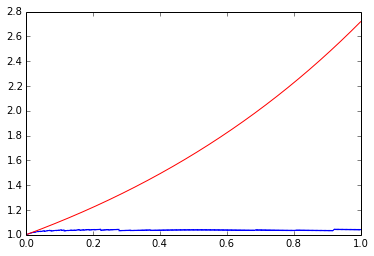

In [77]:
plt.plot(t, y, 'b', t, y_exp, 'r')

In [78]:
errors = []

for exp_, y_ in zip(y_exp, y):
    errors.append(abs(exp_ - y_))

График ошибки, все плохо.

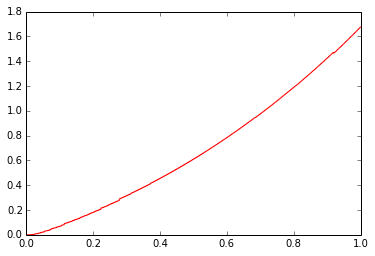

In [80]:
plt.plot(t, errors, 'r')